In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#read raw data
df = pd.read_csv('Book1.csv')

if df.isnull().values.any():
    print ('missing values!')
    #raise ValueError
else:
    print('pass')

removed_mol = ["ASD007", "ASD012", "ASD019", "ASD021", "D372-0163"]
df = df[~df['MolID'].isin(removed_mol)]

df.head()

missing values!


,MolID,A2_pore/wt,A2_pd3-pore/wt,A2_40,A2_80,BalabanJ,BertzCT,Chi0,Chi1,Chi0n,...,Asphericity,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex
0,1500272,1.374142,1.818078,34.31,66.71,1.429,1053.463,24.526,17.092,21.986,...,0.29,0.93,0.000,0.36,0.83,3154.07,7485.30,8960.40,4.71,0.26
1,1501007,1.653595,1.830065,62.53,91.25,1.868,592.306,16.113,10.436,12.477,...,0.61,0.98,0.001,0.16,0.93,794.20,4993.82,5322.33,4.43,0.13
2,1501150,1.263575,1.288084,118.30,197.67,2.143,675.300,17.035,10.863,13.464,...,0.40,0.96,0.001,0.27,0.81,1211.39,3612.58,4454.32,3.82,0.13
3,1503100,1.068571,0.906404,412.39,798.47,1.453,912.788,20.096,13.507,16.903,...,0.50,0.96,0.001,0.24,0.92,1350.32,6512.23,6975.32,4.50,0.21
4,1503243,1.429834,1.796096,336.07,574.06,1.847,673.567,17.527,11.469,13.852,...,0.63,0.98,0.001,0.15,0.93,890.41,6027.54,6455.60,4.67,0.11


In [2]:
Y = df.iloc[:,3]
Y = Y.dropna() # drop row if NaN in Y
#b_class = {'Low': 0, 'High': 1}
#Yb = Y.map(b_class)
Yb = (Y > np.median(Y)).astype(int) # binary classification split by median
Yb#.sum()

0     0
1     0
2     0
3     1
4     1
     ..
81    0
82    1
83    1
84    1
85    0
Name: A2_40, Length: 81, dtype: int64

In [3]:
X_raw = df.iloc[:,5:]
#X_raw = X_raw.drop(index=NANrow)
X_raw.head()

,BalabanJ,BertzCT,Chi0,Chi1,Chi0n,Chi1n,Chi2n,Chi3n,Chi4n,Chi0v,...,Asphericity,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex
0,1.429,1053.463,24.526,17.092,21.986,13.271,10.508,8.949,7.085,21.986,...,0.29,0.93,0.000,0.36,0.83,3154.07,7485.30,8960.40,4.71,0.26
1,1.868,592.306,16.113,10.436,12.477,7.260,5.618,3.565,2.395,12.477,...,0.61,0.98,0.001,0.16,0.93,794.20,4993.82,5322.33,4.43,0.13
2,2.143,675.300,17.035,10.863,13.464,7.701,5.718,4.335,3.048,14.280,...,0.40,0.96,0.001,0.27,0.81,1211.39,3612.58,4454.32,3.82,0.13
3,1.453,912.788,20.096,13.507,16.903,9.734,7.208,5.436,3.662,16.903,...,0.50,0.96,0.001,0.24,0.92,1350.32,6512.23,6975.32,4.50,0.21
4,1.847,673.567,17.527,11.469,13.852,8.151,6.130,4.164,2.612,13.852,...,0.63,0.98,0.001,0.15,0.93,890.41,6027.54,6455.60,4.67,0.11


In [4]:
# scale data using robust scaler
from sklearn.preprocessing import RobustScaler, StandardScaler

#scaler = StandardScaler()
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)

X_scaled.head()

,BalabanJ,BertzCT,Chi0,Chi1,Chi0n,Chi1n,Chi2n,Chi3n,Chi4n,Chi0v,...,Asphericity,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex
0,-0.592908,0.320082,0.959470,0.975976,1.222576,1.072732,1.269823,1.945279,2.467311,1.300478,...,-0.653846,-1.00,-1.0,0.7500,-0.071429,2.611596,0.653941,0.613214,0.583333,1.875
1,0.029787,-0.875948,-0.611879,-0.689690,-0.557469,-0.540526,-0.612394,-0.943133,-1.017088,-0.592991,...,0.576923,0.25,0.0,-0.5000,0.642857,-0.689383,0.112867,-0.113734,0.324074,0.250
2,0.419858,-0.660700,-0.439671,-0.582833,-0.372707,-0.422169,-0.573903,-0.530043,-0.531947,-0.233971,...,-0.230769,-0.25,0.0,0.1875,-0.214286,-0.105819,-0.187096,-0.287177,-0.240741,0.250
3,-0.558865,-0.044765,0.132051,0.078829,0.271060,0.123457,-0.000385,0.060622,-0.075780,0.288331,...,0.153846,-0.25,0.0,0.0000,0.571429,0.088516,0.442619,0.216562,0.388889,1.250
4,0.000000,-0.665194,-0.347777,-0.431181,-0.300075,-0.301396,-0.415319,-0.621781,-0.855869,-0.319196,...,0.653846,0.25,0.0,-0.5625,0.642857,-0.554805,0.337360,0.112713,0.546296,0.000


In [5]:
descriptors = ['NumAliphaticCarbocycles', 'Chi0n', 'NumHDonors', 'FpDensityMorgan2', 'MaxAbsEStateIndex', 'MaxPartialCharge', 'EState_VSA11', 'NPR1', 'EState_VSA2', 'PMI3', 'PMI1', 'EState_VSA8', 'MinEStateIndex', 'NPR2', 'NumHeteroatoms', 'EState_VSA1', 'Kappa3', 'EState_VSA3', 'MolLogP']
X_given = X_scaled[descriptors]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def data_split(X, Y, test_size, random_state=0):
    if not (type(X) is np.ndarray):
        X = X.to_numpy()
    if not (type(Y) is np.ndarray):
        Y = Y.to_numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = test_size, random_state=random_state)

    return X_train, X_test, Y_train, Y_test

#X_train, X_test, Y_train, Y_test = data_split(X_cor, Yb, 0.2)
X_train, X_test, Y_train, Y_test = data_split(X_given, Yb, 0.2)

In [7]:
#PAO1_A2_80
GBDT_tuned_params = {"max_features":'auto',
                  "max_depth": 10,
                  "min_samples_leaf" : 1,
                  'learning_rate': 0.08, 
                  'n_estimators': 250,
                  "subsample": 0.55
                  }

RF_tuned_params = {'max_depth': None,
                   'max_features': 'auto',
                   'min_samples_leaf': 1,
                   'n_estimators': 640,
                  }


LR_tuned_params = {'C': 1, 
                   'penalty': 'l1', 
                   'solver': 'liblinear'
                  }

SVM_tuned_params = {'C': 1,
                    'gamma': 'auto', 
                    'kernel': 'rbf',
                     'probability': True
                    }

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


#K-fold validation function will take six arguments: 
#1. model, 2. train set, 3.test set, 4.# of fold, 5.shuffle boolean, 6.random_state.
def kf_cv(clf, X, y, folds = 10, shuf = True, random_state=42):
    cv = KFold(n_splits=folds, random_state=42, shuffle=shuf)
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    print('Classifier ##{0}## will be used with {1} folds, and shuffle mode is {2}'.format(clf.__class__.__name__,
                                                                                       folds,
                                                                                       'on' if shuf else 'off')
         )
    i = 0
    for train_index, test_index in cv.split(X):
        #turn on the below code will print train_index/test_index and may help understand the details and debug.
        #print("Train Index: ", type(train_index), "\n")
        #print("Test Index: ", test_index)
        
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        #if sampling method is used, use this to avoid warnings: clf.fit(X_train.values, y_train.values.ravel())
        clf.fit(X_train, y_train.ravel())
        
        pred_test = clf.predict(X_test)
        pred_test_probs = clf.predict_proba(X_test)
        #print(pred_test_probs)
        fpr, tpr, _ = roc_curve(y_test,pred_test_probs[:,1]) # use pred_test_probs instead of pred_test
        
        f1.append(f1_score(y_test,pred_test))
        prec.append(precision_score(y_test,pred_test))
        recall.append(recall_score(y_test,pred_test))
        acc.append(accuracy_score(y_test,pred_test))
        ROC_AUC.append(roc_auc_score(y_test, pred_test_probs[:,1]))       
        conf.append(confusion_matrix(y_test,pred_test))

        plt.plot(fpr, tpr, label=str(i))
        i += 1 # plot ROC curve
    
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    #return a dataframe consisting five metrics and confusion matrix.
    return pd.DataFrame(zip(f1,prec,recall,acc,ROC_AUC,conf), columns = metric_cols)

Classifier ##RandomForestClassifier## will be used with 5 folds, and shuffle mode is on


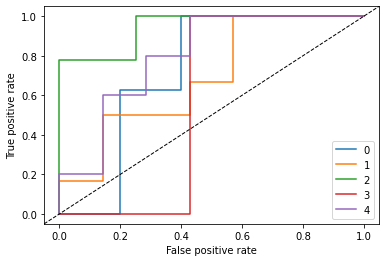



detail results in dictionary "cv_score_dict" using model_name as key
Performace summary in df "cv_score_mean" and "cv_score_sem"


,F1,precision,recall,accuracy,ROC_AUC
RF,0.7,0.7,0.74,0.69,0.75


In [26]:

#make sure datasets are converted from pandas DataFrame into numpy ndarray avoid errors in machine learning.
  
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=0) #same random_state as previous GS

#setting up models using tuned hyperparameters from Grid Search.
#GBDT = GradientBoostingClassifier(random_state=42).set_params(**GBDT_tuned_params)
RF = RandomForestClassifier(random_state=42).set_params(**RF_tuned_params)
LR = LogisticRegression(random_state=42).set_params(**LR_tuned_params)
#SVM = SVC(random_state=42).set_params(**SVM_tuned_params)

#create dictionary to store k-fold CV results
cv_score_dict = {}
#create a dataframe to store the mean and standard error of the mean (SEM) from k-fold CV
cv_score_mean = pd.DataFrame()
cv_score_sem = pd.DataFrame()

#run k-fold CV
for clf, model_name in zip([RF], ['RF']):#'RF','GBDT','LR','SVM'
    #clf = eval(model_name)
    cv_score_dict[model_name] = kf_cv(clf,X_train,Y_train,5,True)
    cv_score_mean[model_name] = cv_score_dict[model_name].mean()[:-1]
    cv_score_sem[model_name] = cv_score_dict[model_name].sem()
    
cv_score_mean = cv_score_mean.transpose().astype(float).round(2)
cv_score_sem = cv_score_sem.transpose().round(2)

print('\n\ndetail results in dictionary "cv_score_dict" using model_name as key')
print('Performace summary in df "cv_score_mean" and "cv_score_sem"')

# check mean performance of each model.
cv_score_mean

In [18]:
cv_score_dict['RF']

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
0,0.714286,0.833333,0.625000,0.692308,0.725000,"[[4, 1], [3, 5]]"
1,0.750000,0.600000,1.000000,0.692308,0.690476,"[[3, 4], [0, 6]]"
2,0.823529,0.875000,0.777778,0.769231,0.944444,"[[3, 1], [2, 7]]"
3,0.500000,0.500000,0.500000,0.538462,0.571429,"[[4, 3], [3, 3]]"
4,0.727273,0.666667,0.800000,0.750000,0.800000,"[[5, 2], [1, 4]]"
